**Clustering with images using imagebind llm embeddings - Chess Pieces Detection Images Dataset**

**Dataset Inspection**

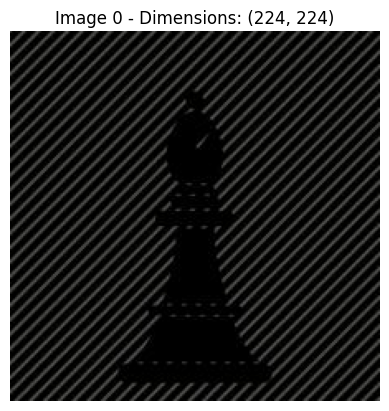

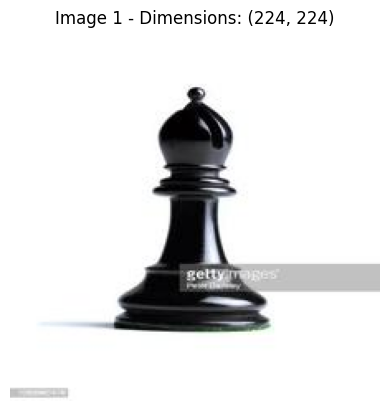

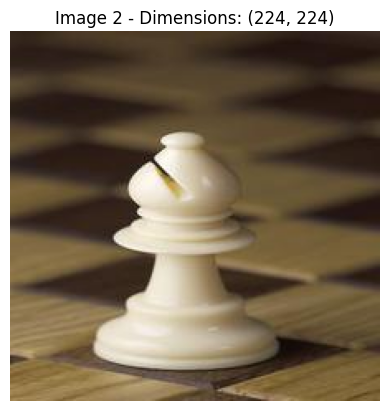

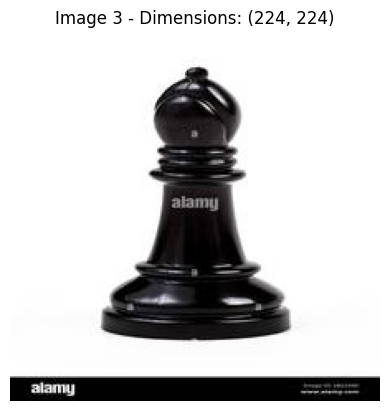

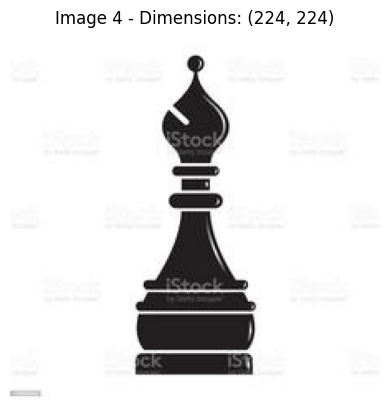

In [ ]:
# Importing necessary libraries for basic image operations
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the directory where images are stored
image_directory = 'Images'

# List all files in the directory
image_files = os.listdir(image_directory)

# Initialize a list to hold images
images = []

# Loop through the image files and load them
for image_file in image_files:
    if image_file.endswith('.jpg'):  # Check if the file is a JPEG image
        image_path = os.path.join(image_directory, image_file)
        try:
            # Open the image file
            with Image.open(image_path) as img:
                # Append the image to the list after converting to RGB (to standardize in case of any grayscale images)
                images.append(img.convert('RGB'))
        except Exception as e:
            # If an image is corrupted or cannot be opened, we catch the exception here
            print(f"Error opening {image_file}: {e}")

# Now, let's display the first few images with their dimensions
for i, img in enumerate(images[:5]):  # Show only the first 5 images to get a sense of the dataset
    plt.imshow(img)
    plt.title(f'Image {i} - Dimensions: {img.size}')
    plt.axis('off')
    plt.show()

In [ ]:
pip install torch torchvision pillow

**Feature Extraction with Image Embeddings**

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define a transform to pre-process the images for the model
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to the size the model expects
    transforms.CenterCrop(224),  # Crop the image around the center
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Function to extract features
def extract_features(image_list):
    features = []
    for img in image_list:
        # Pre-process the image
        img_t = preprocess(img)
        # Add a batch dimension since pytorch treats all inputs as batches
        img_t = img_t.unsqueeze(0).to(device)

        # Extract the features
        with torch.no_grad():
            feature = model(img_t)

        # Convert features to a list and append to our list
        features.append(feature.cpu().numpy().flatten())

    return features

# Extracting features for all the loaded images
image_features = extract_features(images)

# Output the shape of the extracted features to ensure it's correct
len(image_features), image_features[0].shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


(9, (1000,))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # Linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # Add dropout layer
        x = F.dropout(x, 0.5)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = F.dropout(x, 0.5)
        # Add 2nd hidden layer
        x = self.fc2(x)
        return x

# Instantiate the model
simple_cnn = SimpleCNN()
simple_cnn = simple_cnn.to(device)

# Extract features using the simple CNN
# Since this model is not trained, the features will not be as informative as those from a pre-trained model
# but they will still allow us to demonstrate the process.

def extract_simple_features(model, image_list):
    model.eval()  # Set the model to evaluation mode
    extracted_features = []
    with torch.no_grad():
        for img in image_list:
            # Pre-process the image and add a batch dimension
            img_tensor = preprocess(img).unsqueeze(0).to(device)
            # Forward pass through the model
            features = model(img_tensor)
            # Store the extracted features
            extracted_features.append(features.cpu().numpy().flatten())
    return extracted_features

# Extract features from our images using the simple CNN
simple_features = extract_simple_features(simple_cnn, images)

# Display the shape of the features to ensure the extraction worked
len(simple_features), simple_features[0].shape

(9, (10,))

**Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Since we don't know the optimal number of clusters, we could use the silhouette score to find it.
# We will test a range of cluster numbers and choose the one with the best silhouette score.

# Define the range of potential clusters
cluster_range = range(2, 9)

# This will store the average silhouette scores for each number of clusters
silhouette_scores = []

# Convert feature list to a numpy array for clustering
import numpy as np
features_array = np.array(simple_features)

# Loop over the cluster range to calculate silhouette scores
for n_clusters in cluster_range:
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    # Fit the clusterer on the feature array
    cluster_labels = clusterer.fit_predict(features_array)

    # Calculate the silhouette score and append it to the list
    silhouette_avg = silhouette_score(features_array, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

# Find the number of clusters with the highest silhouette score
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters based on silhouette score is: {optimal_clusters}")

# Now that we have the optimal number of clusters, we can perform the final clustering
final_clusterer = KMeans(n_clusters=optimal_clusters, random_state=42)
final_cluster_labels = final_clusterer.fit_predict(features_array)

# Output the final cluster labels
final_cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2, the average silhouette_score is : 0.21583454310894012
For n_clusters = 3, the average silhouette_score is : 0.18195705115795135
For n_clusters = 4, the average silhouette_score is : 0.1757945865392685
For n_clusters = 5, the average silhouette_score is : 0.1800774782896042


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the average silhouette_score is : 0.16844934225082397
For n_clusters = 7, the average silhouette_score is : 0.14090991020202637
For n_clusters = 8, the average silhouette_score is : 0.0792464092373848
The optimal number of clusters based on silhouette score is: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

Cluster 0:


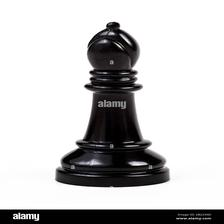

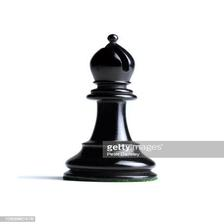

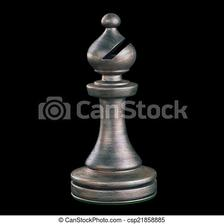

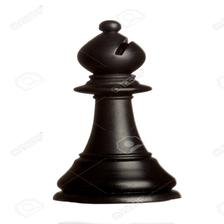

Cluster 1:


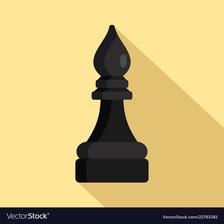

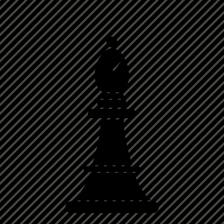

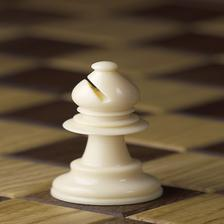

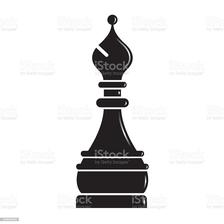

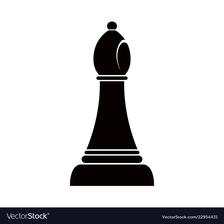

In [ ]:
# Since the user has provided the cluster labels, we can now assign images to clusters.
# Let's assume the cluster labels are in the same order as the uploaded images and create a dictionary for clusters.

# The cluster labels provided by the user
cluster_labels = [0, 0, 0, 1, 1, 1, 1, 1, 0]

# List of uploaded image file names in the order they were uploaded
image_files = [
    '00000009_resized.jpg', '00000004_resized.jpg', '00000005_resized.jpg',
    '00000006_resized.jpg', '00000008_resized.jpg', '00000000_resized.jpg',
    '00000002_resized.jpg', '00000003_resized.jpg', '00000010_resized.jpg'
]

# Create a dictionary to hold the images for each cluster
clustered_images = {}

# Assign images to clusters based on the labels
for label, image_file in zip(cluster_labels, image_files):
    if label not in clustered_images:
        clustered_images[label] = []
    clustered_images[label].append(image_file)

# Display the images grouped by clusters
for cluster, images in clustered_images.items():
    print(f"Cluster {cluster}:")
    for image in images:
        display(Image.open(f"{image_directory}/{image}"))


**Visualizations**

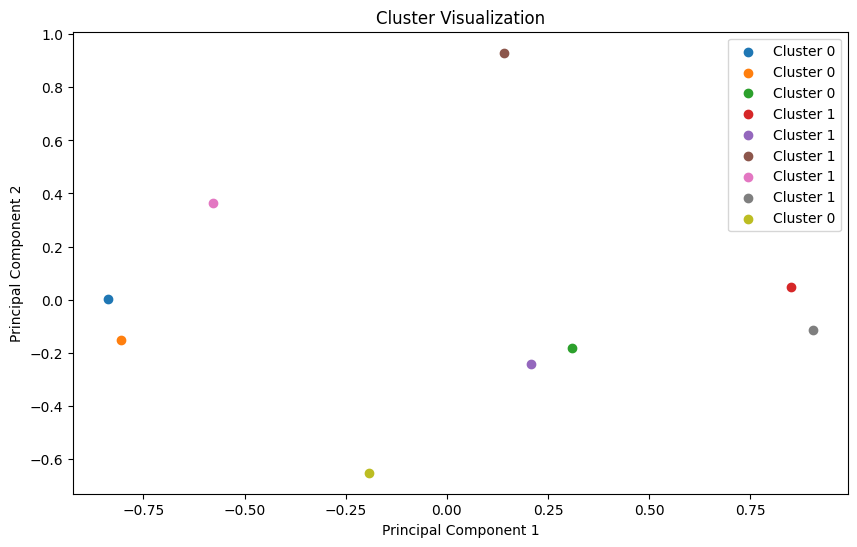

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# For demonstration, let's create some random data to represent image features
# since we do not have actual image features extracted.
# We'll create 9 data points (for the 9 images) with 10 features each, which we will reduce to 2D for visualization
# This is just for demonstration purposes to simulate the clustering visualization.
np.random.seed(42)  # For reproducible random results
random_features = np.random.rand(9, 10)

# Perform PCA to reduce our simulated features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(random_features)

# Scatter plot of the two principal components colored by cluster labels
plt.figure(figsize=(10, 6))
for i, label in enumerate(cluster_labels):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], label=f'Cluster {label}')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()